In [1]:
import itertools
from itertools import cycle

# Math
import numpy as np
import pandas as pd

# Bio
from Bio import motifs, SeqIO
from Bio.Align import Applications
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# custom
from unidip import UniDip
from util import *

import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
muscle_exe = r"./muscle3.8.31_i86linux64"
in_file = r"./generated1.fasta"
out_file = r"./generatedaligned1.fasta"

In [119]:
# mis-aligned
# strings = gen_mut_strs(pattern="ACTGTGCACGTGACG", mut_num=6, insert_num=1, noise_len=100, noise_var=3, number=100)
motif = "CAAGTCCTGAATCG"
labs, strings = gen_mut_strs(motif, 1, 20, 500, min_offset=0, max_offset=470, mutate_num=0)
seqs = [SeqRecord(Seq(s), id=f"Seq{i}", description="Generated Sequence") for i, s in zip(range(len(strings)), strings)]

In [120]:
SeqIO.write(seqs, in_file, 'fasta')

20

In [121]:
muscle_cline = Applications.MuscleCommandline(muscle_exe, input=in_file, out=out_file)
muscle_cline()
print(muscle_cline)

./muscle3.8.31_i86linux64 -in ./generated1.fasta -out ./generatedaligned1.fasta


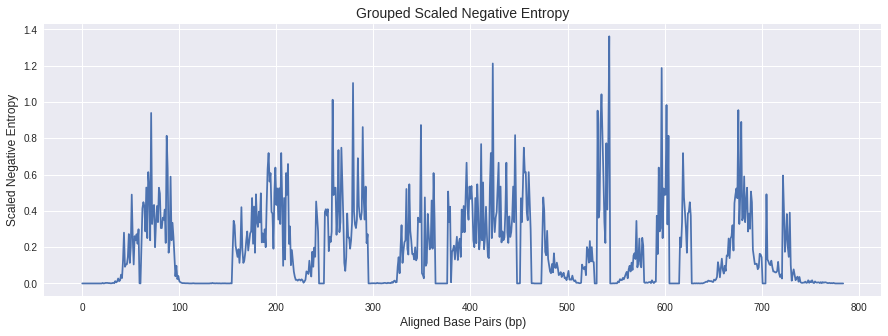

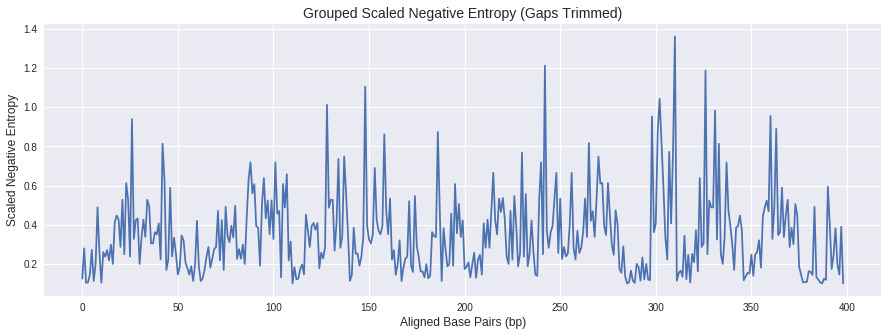

In [122]:
alignedSeqs = list(SeqIO.parse(out_file, "fasta"))

# plt.figure(figsize=[15, 15])
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Frequency Counts
cts = pd.DataFrame([[let for let in str(s.seq)] for s in alignedSeqs]).apply(pd.value_counts).fillna(0).T.to_dict()
for p, n in cts['-'].items():
    for let in "ACGT":
        cts[let][p] += n

# ax1 = plt.subplot('311')
# for let in "ACGT-":
#     plt.plot(list(cts[let].values()), label=let, ls=next(linecycler))
# plt.title("Point Frequencies", fontsize=14)
# plt.ylabel("Frequency", fontsize=12)
# # plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# # plt.xticks(range(0,len(strings[0])+1,5), rotation='vertical')
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.legend(fontsize=12)

# # information content
# ic = pd.DataFrame(cts).apply(getInfoCntnt, 1)

# plt.subplot('312')
# for col in ic:
#     plt.plot(ic[col], label=col, ls=next(linecycler))
# plt.title("Individual Information Content", fontsize=14)
# plt.ylabel("Information Content", fontsize=12)
# plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# # plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(ic.columns.values, fontsize=12)
# plt.style.use("seaborn")
# plt.show()

# negative scaled entropy
nent = pd.DataFrame(cts).apply(lambda x: 2-shannonEntropy(x), 1) 

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent, label="Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
plt.style.use("seaborn")
plt.show()

nent_trimmed = nent[nent > 0.1].reset_index()

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent_trimmed[0], label="Trimmed Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy (Gaps Trimmed)", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
plt.style.use("seaborn")
plt.show()


In [123]:
res = UniDip(np.array(nent), alpha=.01, is_hist=True, merge_distance=10, debug=False).run()
print(len(res))
print(res)

12
[(44, 97), (156, 214), (250, 291), (328, 362), (391, 461), (474, 489), (514, 542), (594, 603), (616, 626), (654, 689), (734, 745), (761, 776)]


In [124]:
alph = 0.05
res1 = UniDip(np.array(nent_trimmed[0]), alpha=alph, is_hist=True, merge_distance=10, debug=False).run()
print(len(res1))
print(res1)
if len(res1) == 1:
    res1 = [UniDip(np.array(nent_trimmed[0]), alpha=alph, is_hist=True, merge_distance=10, debug=False)._get_full_interval(res1[0])]
print(len(res1))
print(res1)

1
[(0, 398)]
1
[(87, 375)]


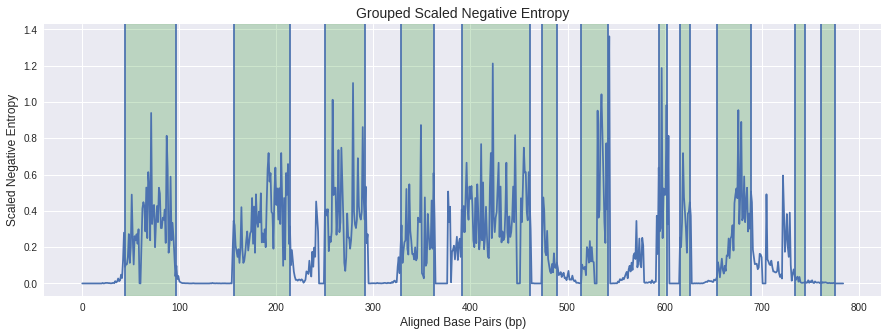

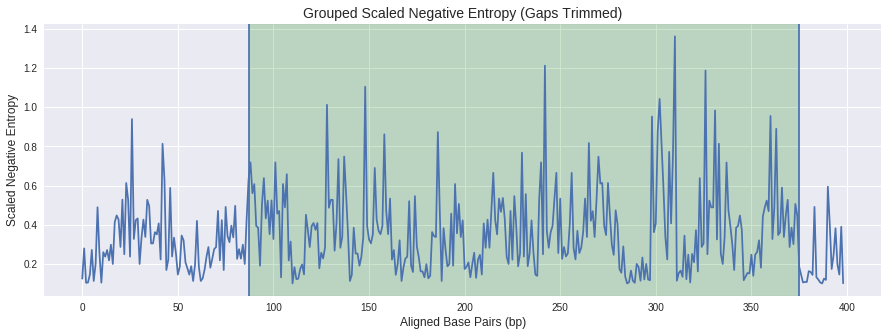

In [125]:
plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent, label="Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
for lo, hi in res:
    plt.axvline(lo)
    plt.axvline(hi)
    plt.axvspan(lo, hi, color='green', alpha=0.2)
plt.style.use("seaborn")
plt.show()

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent_trimmed[0], label="Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy (Gaps Trimmed)", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
for lo, hi in res1:
    plt.axvline(lo)
    plt.axvline(hi)
    plt.axvspan(lo, hi, color='green', alpha=0.2)
plt.style.use("seaborn")
plt.show()

In [36]:
isolatedSeqs = []
for clus in res:
    isolatedSeqs.append([])
    for seq in alignedSeqs:
        isolatedSeqs[-1].append(seq[clus[0]-20:clus[1]+21])
for i, sr in zip(range(len(isolatedSeqs)), isolatedSeqs):
    SeqIO.write(sr, f'isolatedRegionsCluster{i}.fasta', 'fasta')

In [1]:
origSeqs = list(SeqIO.parse(in_file, "fasta"))
def get_diffs(res, aligned, labs):
    clustStartSites, diffs = [], []
    al_len = len(aligned[0])
    for clus in res:
        clustStartSites.append([])
        for seq in aligned:
            clustStartSites[-1].append(clus[0]-str(seq.seq).count('-', 0, clus[0]))
    
    for css in clustStartSites:
        diffs.append(list(map(lambda a, b: np.sqrt((a[0] - b) ** 2), labs, css)))
    
    return [sum(d) /len(d) for d in diffs], diffs


def get_trim_diffs(res, alignedA, alignedT, labs):
    trimStartSites, diffs = [], []
    for cl in res:
        idxs = alignedT.iloc[cl[0]:cl[1],:]["index"]
        trimStartSites.append([])
        for seq in alignedA:
            strt = idxs.iloc[0]
            trimStartSites[-1].append(strt-str(seq.seq).count('-', 0, strt))
    
    for tss in trimStartSites:
        diffs.append(list(map(lambda a, b: np.sqrt((a[0] - b) ** 2), labs, tss)))
    
    return [sum(d) / len(d) for d in diffs], diffs


def get_coverage(res, alignedA, alignedT, labs):
    trimStartSites, trimEndSites, diffs = [], [], []
    for cl in res:
        idxs = alignedT.iloc[cl[0]:cl[1],:]["index"]
        trimStartSites.append([])
        trimEndSites.append([])
        for seq in alignedA:
            strt = idxs.iloc[0]
            end = idxs.iloc[-1]
            trimStartSites[-1].append(strt-str(seq.seq).count('-', 0, strt))
            trimEndSites[-1].append(end-str(seq.seq).count('-', 0, end))
    
    for pss, pes in zip(trimStartSites, trimEndSites):
        is_covered = list(map(lambda ms, ps, pe: (ps < ms[0] < pe or ps < ms[0]+15 < pe), labs, pss, pes))
        diffs.append(is_covered)
    
    return [sum(d) / len(d) for d in diffs], diffs

NameError: name 'SeqIO' is not defined

In [127]:
get_diffs(res, alignedSeqs, labs)[0]

[263.55,
 212.25,
 163.3,
 142.65,
 129.85,
 127.6,
 129.5,
 145.5,
 151.55,
 163.7,
 211.3,
 222.15]

In [131]:
nent_trimmed[0].shape[0]

399

[0.7]
Cluster 1 mean conservation 0.37798984117783047


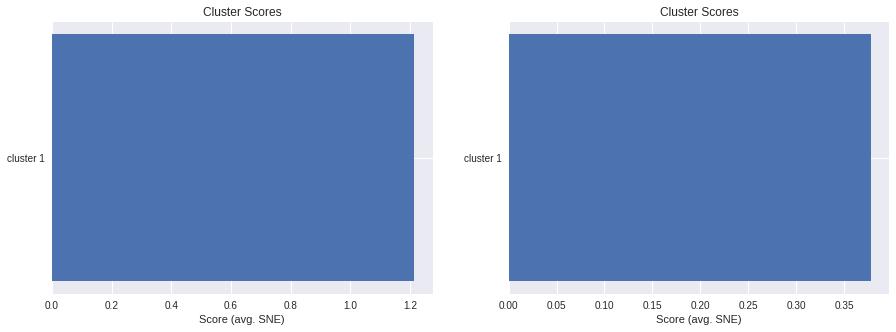

In [128]:
avg_dff, dffs = get_coverage(res1, alignedSeqs, nent_trimmed, labs)
print(avg_dff)
scores = score(res1, nent_trimmed[0]).values()

plt.figure(figsize=[15, 5])

# ax = plt.subplot("121")
# plt.boxplot(dffs,  0, 'rs', 0)
# plt.title("Cluster Error")
# plt.xlabel("RSE (distance from start site)")
# # ax.set_yticks(range(1, len(dffs) + 1))
# ax.set_yticklabels([f"cluster {i + 1}" for i in range(len(dffs))])

ax = plt.subplot("121")
plt.barh([f"cluster {i + 1}" for i in range(len(scores))], [a / ((r[1]-r[0])/500) for r, a in zip(res1, avg_dff)], align="center")
plt.title("Cluster Scores")
plt.xlabel("Score (avg. SNE)")


ax = plt.subplot("122")
plt.barh([f"cluster {i + 1}" for i in range(len(scores))], list(scores), align="center")
plt.title("Cluster Scores")
plt.xlabel("Score (avg. SNE)")

# plt.ylabel("")
plt.show()

In [117]:
oriSeqs = list(SeqIO.parse("./1000samp/1000sampGenerated.fasta", "fasta"))

def write_trim_align(res, Oseq, Aseq, Tnent):
    trimmedSeqs = []
    for cl in res:
        trimmedSeqs.append([])
        aligned_idxs = Tnent.iloc[cl[0]:cl[1],:]["index"]
        for Oseq, Aseq in zip(sorted(oriSeqs, key=lambda s: s.id), sorted(alignedSeqs, key=lambda s: s.id)):
            assert Oseq.id == Aseq.id, f"{Oseq.id} != {Aseq.id}"
            strt = aligned_idxs.iloc[0]
            stop = aligned_idxs.iloc[-1]
            nsqs = Oseq[strt-str(Aseq.seq).count('-', 0, strt) - 15 : stop-str(Aseq.seq).count('-', 0, stop) + 15]
            trimmedSeqs[-1].append(nsqs)
        SeqIO.write(trimmedSeqs[-1], f'./1000samp/TrimmedCluster{len(trimmedSeqs)}.fasta', 'fasta')

In [118]:
write_trim_align(res1, oriSeqs, alignedSeqs, nent_trimmed)

In [20]:
def run_trials(ntrials, **kwargs):
    errors = []
    motif = "ACGTTGTACTAGATCA"
    muscle_cline = Applications.MuscleCommandline(muscle_exe, input=in_file, out=out_file)
    for i in range(ntrials):
        # gen strs
        labs, strings = gen_mut_strs(motif, **kwargs)
        seqs = [SeqRecord(Seq(s), id=f"Seq{i}", description="Generated Sequence") for i, s in zip(range(len(strings)), strings)]
        SeqIO.write(seqs, in_file, 'fasta')

        # alignment
        muscle_cline()
        alignedSeqs = list(SeqIO.parse(out_file, "fasta"))

        # run UniDip
        cts = pd.DataFrame([[let for let in str(s.seq)] for s in alignedSeqs]).apply(pd.value_counts).fillna(0).T.to_dict()
        nent = pd.DataFrame(cts).apply(lambda x: -shannonEntropy(x), 1) 
        nent -= nent.min()
        nent_trimmed = nent[nent > 0.01].reset_index()
        res1 = UniDip(np.array(nent_trimmed[0]), alpha=.05, is_hist=True, merge_distance=10, debug=False).run()
        if len(res1) == 1:
            res1 = [UniDip(np.array(nent_trimmed[0]), alpha=.05, is_hist=True, merge_distance=10, debug=False)._get_full_interval(res1[0])]


        # get diffs
        errors.append(min(get_trim_diffs(res1, alignedSeqs, nent_trimmed, labs)[0]))
    return errors


def test_parameters(ntrials=100, **kwargs):
    """
        default parameters:
            insert_num=1,
            Nstrs=50,
            str_len=100,
            min_offset = ((str_len//insert_num)//2) if min_offset == None else min_offset
            max_offset = min_offset if max_offset == None else max_offset
            min_gap = str_len//insert_num if min_gap == None else min_gap
            max_gap = min_gap if max_gap == None else max_gap 
            mutate_num = 0 if mutate_num == None else mutate_num
    """
    dat = {'trials': [], "idx": []}
    
    for k, v in kwargs.items():
        assert type(v) == list, "arguments must be lists"
        
    vals = list(itertools.product(*kwargs.values()))
    keys = list(itertools.repeat(list(kwargs.keys()), len(vals)))
    for idx, dct in zip(range(len(vals)), [dict(map(list, zip(x, y))) for x, y in zip(keys, vals)]):   
            print(f"Testing {list(dct.keys())} with perameters {list(dct.values())}")
            dat['trials'].append(run_trials(ntrials, **dct))
            dat['idx'].append(f"Trial{idx}: params: {dct}")
        
    print("done")
    return dat

In [26]:
dat = test_parameters(Nstrs=[10, 20], str_len=[200], min_offset=[50], max_offset=[50], mutate_num=[5])

Testing ['Nstrs', 'str_len', 'min_offset', 'max_offset', 'mutate_num'] with perameters [10, 200, 50, 50, 5]
Testing ['Nstrs', 'str_len', 'min_offset', 'max_offset', 'mutate_num'] with perameters [20, 200, 50, 50, 5]
done


In [263]:
d = {'a': 0, 'b': 0}
d.get('a') == None
print(d.get('b') == None)
print(not d.get('b'))

False
True


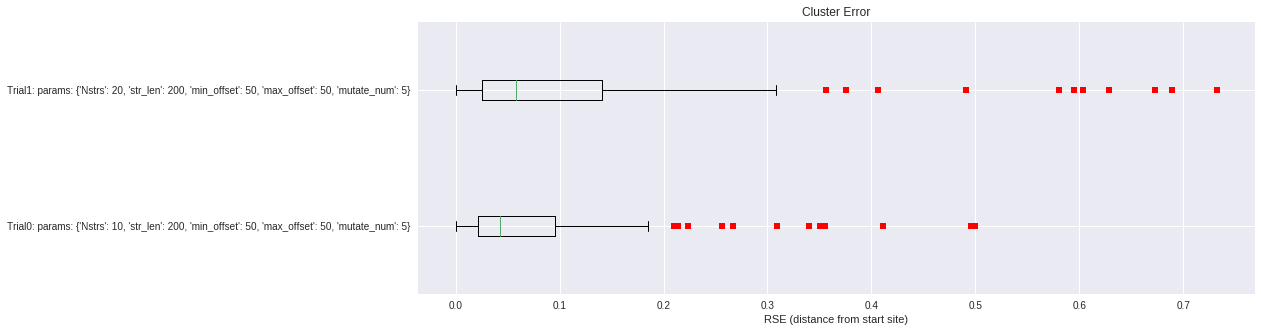

In [27]:
plt.figure(figsize=[15, 5])
plt.boxplot(dat["trials"],  0, 'rs', 0, labels=dat["idx"])
plt.title("Cluster Error")
plt.xlabel("RSE (distance from start site)")
plt.ylabel("")

plt.show()

In [ ]:
# plt.title('cumulative sum of histogram bin heights')
# plt.plot(list(range(len(nent))), np.cumsum(nent))
# plt.show()

In [46]:
# np.savetxt("reasonableAligned.csv", nent)

In [9]:
# [str(s.seq).replace("-", "") for s in alignedSeqs[:10]]